In [2]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 24 kB/s 


In [3]:
import SimpleITK as sitk
import os
import numpy as np

import sys
import random

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [4]:
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, Input, Cropping2D, Flatten, UpSampling2D, BatchNormalization
from keras.models import Model
from tensorflow import keras
import tensorflow as tf

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Modelo U-NET1

In [6]:
model1 = keras.models.Sequential([
    
    keras.layers.Input(shape=(256,256,3)),                              
    #D1                            
    keras.layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same'),
    keras.layers.Conv2D(32, (3,3), activation = 'relu',padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #D2
    keras.layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same'),
    keras.layers.Conv2D(32, (3,3), activation = 'relu',padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #D3
    keras.layers.Conv2D(64, (3,3), activation = 'relu',padding = 'same'),
    keras.layers.Conv2D(64, (3,3), activation = 'relu',padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    #D4
    keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2, padding='same'),
    #D5
    keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    #D6
    keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    keras.layers.Conv2D(128, (3,3), activation = 'relu'),

    #U1
    keras.layers.UpSampling2D(size=(2,2)),
    keras.layers.Conv2D(128, (3,3), activation = 'relu', padding='same'),
    keras.layers.Conv2D(128, (3,3), activation = 'relu', padding='same'),
    #U2
    keras.layers.UpSampling2D(size=(2,2)),
    keras.layers.Conv2D(128, (3,3), activation = 'relu', padding='same'),
    keras.layers.Conv2D(128, (3,3), activation = 'relu', padding='same'),
    #U3
    keras.layers.UpSampling2D(size=(2,2)),
    keras.layers.Conv2D(64, (3,3), activation = 'relu', padding='same'),
    keras.layers.Conv2D(64, (3,3), activation = 'relu', padding='same'),
    #U4
    keras.layers.UpSampling2D(size=(2,2)),
    keras.layers.Conv2D(32, (3,3), activation = 'relu', padding='same'),
    keras.layers.Conv2D(32, (3,3), activation = 'relu', padding='same'),
    #U5
    keras.layers.UpSampling2D(size=(2,2)),
    keras.layers.Conv2D(16, (3,3), activation = 'relu', padding='same'),
    keras.layers.Conv2D(16, (3,3), activation = 'relu', padding='same'),
    #SEG
    keras.layers.Conv2D(4,(1,1), activation ='softmax'),
])

In [7]:
input_shape=(256,256,3)
model1.build(input_shape)
#model1.summary()
#keras.utils.plot_model(model1, to_file = "Model.png", show_shapes=True)

In [8]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### No modelo U-net 1 a imagem de entrada tem que ter as dimensões: (None, 256,256,3)
### A imagem que sai (mascara) tem de dimensões: (None, 32,32,4)

# Paciente 1

In [ ]:
dataset_dir='/content/drive/MyDrive/testing1/patient0001'
# Path to mhd images (not gt)
image_ids = []
# r=root, d=directories, f = files
for r, d, f in os.walk(dataset_dir):
    for file in f:    
        if ('ED.mhd' in file) or ('ES.mhd' in file):
            image_ids.append(os.path.join(r, file))

image_ids.sort()
images=[]
for image in image_ids:
  #plt.figure(figsize=(12,8))
  #plt.subplot(141)
  image=sitk.GetArrayFromImage(sitk.ReadImage(image,sitk.sitkFloat32))
  image = image[0,:,:] #2D grayscale image
  image=cv2.resize(image,(256,256))
  image=image/255
  image_f=np.stack((image,image,image),axis=2)
  #plt.imshow(image_f)
  images.append(image_f)
  #plt.show()


image_dataset=np.array(images)

In [ ]:
print(image_dataset.shape)

(4, 256, 256, 3)


['/content/drive/MyDrive/testing1/patient0001/patient0001_2CH_ED_gt0.mhd', '/content/drive/MyDrive/testing1/patient0001/patient0001_2CH_ES_gt0.mhd', '/content/drive/MyDrive/testing1/patient0001/patient0001_4CH_ED_gt0.mhd', '/content/drive/MyDrive/testing1/patient0001/patient0001_4CH_ES_gt0.mhd']


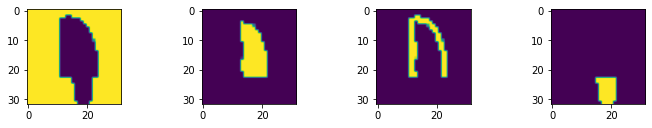

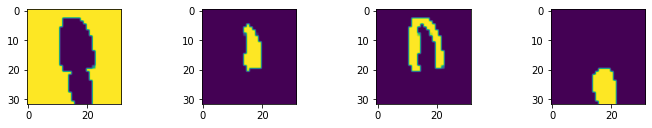

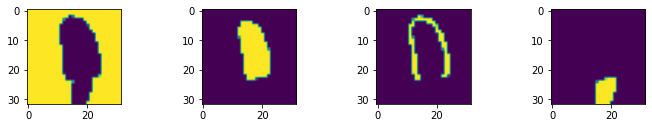

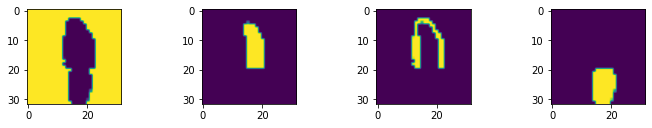

In [ ]:
dataset_dir='/content/drive/MyDrive/testing1/patient0001'
# Path to mhd images (not gt)
mask0_ids = []
mask1_ids = []
mask2_ids = []
mask3_ids = []
# r=root, d=directories, f = files
for r, d, f in os.walk(dataset_dir):
    for file in f:    
        if ('ED.mhd' in file) or ('ES.mhd' in file):
            mask0_ids.append(os.path.join(r, file)[:-4]+"_gt0.mhd")
            mask1_ids.append(os.path.join(r, file)[:-4]+"_gt1.mhd")
            mask2_ids.append(os.path.join(r, file)[:-4]+"_gt2.mhd")
            mask3_ids.append(os.path.join(r, file)[:-4]+"_gt3.mhd")
      
mask0_ids.sort()
print(mask0_ids)
mask1_ids.sort()
mask2_ids.sort()
mask3_ids.sort()
masks=[]

for i in range(4):

  plt.figure(figsize=(12,8))
  plt.subplot(441)
  mask0_1=sitk.GetArrayFromImage(sitk.ReadImage(mask0_ids[i],sitk.sitkFloat32))
  mask0_2=cv2.resize(mask0_1,(32,32))
  plt.imshow(mask0_2)
  plt.subplot(442)
  mask1_1=sitk.GetArrayFromImage(sitk.ReadImage(mask1_ids[i],sitk.sitkFloat32))
  mask1_2=cv2.resize(mask1_1,(32,32))
  plt.imshow(mask1_2)
  plt.subplot(443)
  mask2_1=sitk.GetArrayFromImage(sitk.ReadImage(mask2_ids[i],sitk.sitkFloat32))
  mask2_2=cv2.resize(mask2_1,(32,32))
  plt.imshow(mask2_2)
  plt.subplot(444)
  mask3_1=sitk.GetArrayFromImage(sitk.ReadImage(mask3_ids[i],sitk.sitkFloat32))
  mask3_2=cv2.resize(mask3_1,(32,32))
  plt.imshow(mask3_2)
  plt.show()
  mask_f=np.stack((mask0_2, mask1_2,mask2_2,mask3_2),axis=2)
  masks.append(mask_f)

mask_dataset=np.array(masks)

# Todos os dados de treino

In [9]:
dataset_dir='/content/drive/MyDrive/training'
# Path to mhd images (not gt)
image_ids = []
# r=root, d=directories, f = files
for r, d, f in os.walk(dataset_dir):
    for file in f:    
        if ('ED.mhd' in file) or ('ES.mhd' in file):
            image_ids.append(os.path.join(r, file))

image_ids.sort()
images=[]
for image in image_ids:
  #plt.figure(figsize=(12,8))
  #plt.subplot(141)
  image=sitk.GetArrayFromImage(sitk.ReadImage(image,sitk.sitkFloat32))
  image = image[0,:,:] #2D grayscale image
  image=cv2.resize(image,(256,256))
  image=image/255
  image_f=np.stack((image,image,image),axis=2)
  #plt.imshow(image_f)
  images.append(image_f)
  #plt.show()


image_dataset=np.array(images)

In [10]:
xtrain=image_dataset[:1080]
xval=image_dataset[1080:]

In [11]:
print(xtrain.shape)
print(xval.shape)

(1080, 256, 256, 3)
(120, 256, 256, 3)


In [17]:
dataset_dir='/content/drive/MyDrive/training'
# Path to mhd images (not gt)
mask0_ids = []
mask1_ids = []
mask2_ids = []
mask3_ids = []
# r=root, d=directories, f = files
for r, d, f in os.walk(dataset_dir):
    for file in f:    
        if ('ED.mhd' in file) or ('ES.mhd' in file):
            mask0_ids.append(os.path.join(r, file)[:-4]+"_gt0.mhd")
            mask1_ids.append(os.path.join(r, file)[:-4]+"_gt1.mhd")
            mask2_ids.append(os.path.join(r, file)[:-4]+"_gt2.mhd")
            mask3_ids.append(os.path.join(r, file)[:-4]+"_gt3.mhd")
      
mask0_ids.sort()
print(mask0_ids)
mask1_ids.sort()
mask2_ids.sort()
mask3_ids.sort()
masks=[]

for i in range(1200):

  #plt.figure(figsize=(12,8))
  #plt.subplot(441)
  mask0_1=sitk.GetArrayFromImage(sitk.ReadImage(mask0_ids[i],sitk.sitkFloat32))
  mask0_2=cv2.resize(mask0_1,(32,32))
  #plt.imshow(mask0_2)
  #plt.subplot(442)
  mask1_1=sitk.GetArrayFromImage(sitk.ReadImage(mask1_ids[i],sitk.sitkFloat32))
  mask1_2=cv2.resize(mask1_1,(32,32))
  #plt.imshow(mask1_2)
  #plt.subplot(443)
  mask2_1=sitk.GetArrayFromImage(sitk.ReadImage(mask2_ids[i],sitk.sitkFloat32))
  mask2_2=cv2.resize(mask2_1,(32,32))
  #plt.imshow(mask2_2)
  #plt.subplot(444)
  mask3_1=sitk.GetArrayFromImage(sitk.ReadImage(mask3_ids[i],sitk.sitkFloat32))
  mask3_2=cv2.resize(mask3_1,(32,32))
  #plt.imshow(mask3_2)
  #plt.show()
  mask_f=np.stack((mask0_2, mask1_2,mask2_2,mask3_2),axis=2)
  masks.append(mask_f)

mask_dataset=np.array(masks)

['/content/drive/MyDrive/training/patient0051/patient0051_2CH_ED_gt0.mhd', '/content/drive/MyDrive/training/patient0051/patient0051_2CH_ES_gt0.mhd', '/content/drive/MyDrive/training/patient0051/patient0051_4CH_ED_gt0.mhd', '/content/drive/MyDrive/training/patient0051/patient0051_4CH_ES_gt0.mhd', '/content/drive/MyDrive/training/patient0052/patient0052_2CH_ED_gt0.mhd', '/content/drive/MyDrive/training/patient0052/patient0052_2CH_ES_gt0.mhd', '/content/drive/MyDrive/training/patient0052/patient0052_4CH_ED_gt0.mhd', '/content/drive/MyDrive/training/patient0052/patient0052_4CH_ES_gt0.mhd', '/content/drive/MyDrive/training/patient0053/patient0053_2CH_ED_gt0.mhd', '/content/drive/MyDrive/training/patient0053/patient0053_2CH_ES_gt0.mhd', '/content/drive/MyDrive/training/patient0053/patient0053_4CH_ED_gt0.mhd', '/content/drive/MyDrive/training/patient0053/patient0053_4CH_ES_gt0.mhd', '/content/drive/MyDrive/training/patient0054/patient0054_2CH_ED_gt0.mhd', '/content/drive/MyDrive/training/pati

In [18]:
ytrain=mask_dataset[:1080]
yval=mask_dataset[1080:]

In [19]:
print(ytrain.shape)
print(yval.shape)

(1080, 32, 32, 4)
(120, 32, 32, 4)


In [ ]:
print(image_dataset.shape)
print(mask_dataset.shape)

(1000, 256, 256, 3)
(1000, 32, 32, 4)


#Treinar o modelo

In [20]:
historyval=model1.fit(xtrain,ytrain, epochs=30,batch_size=32, validation_data=(xval,yval))
model1.save('model1_300val.h5')

Epoch 1/30
34/34 [==============================] - 331s 10s/step - loss: 1.3263 - accuracy: 0.7312 - val_loss: 1.1087 - val_accuracy: 0.7623
Epoch 2/30
34/34 [==============================] - 324s 10s/step - loss: 0.6245 - accuracy: 0.7727 - val_loss: 0.3833 - val_accuracy: 0.8399
Epoch 3/30
34/34 [==============================] - 327s 10s/step - loss: 0.3585 - accuracy: 0.8514 - val_loss: 0.3517 - val_accuracy: 0.8558
Epoch 4/30
34/34 [==============================] - 322s 9s/step - loss: 0.3438 - accuracy: 0.8566 - val_loss: 0.3193 - val_accuracy: 0.8681
Epoch 5/30
34/34 [==============================] - 332s 10s/step - loss: 0.3354 - accuracy: 0.8584 - val_loss: 0.3241 - val_accuracy: 0.8674
Epoch 6/30
34/34 [==============================] - 324s 10s/step - loss: 0.3350 - accuracy: 0.8584 - val_loss: 0.3244 - val_accuracy: 0.8662
Epoch 7/30
34/34 [==============================] - 329s 10s/step - loss: 0.3335 - accuracy: 0.8588 - val_loss: 0.3154 - val_accuracy: 0.8684
Epoch 8

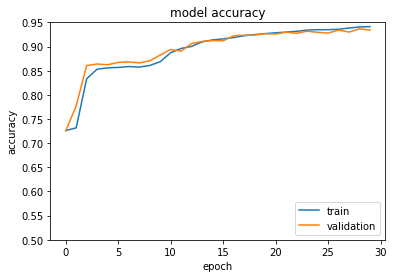

In [ ]:
#200 pacientes
plt.plot(historyval.history['accuracy'])
plt.plot(historyval.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.ylim([0.5, 0.95])
plt.show()

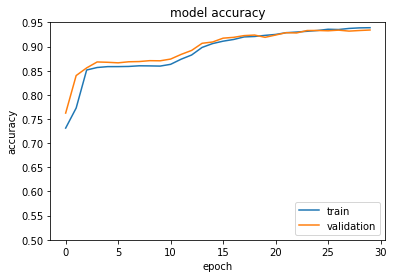

In [21]:
#300 pacientes
plt.plot(historyval.history['accuracy'])
plt.plot(historyval.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.ylim([0.5, 0.95])
plt.show()

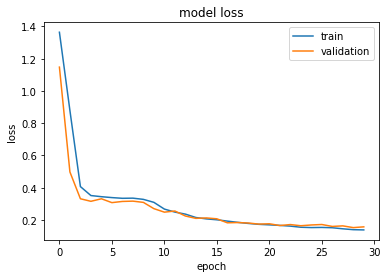

In [ ]:
#200 pacientes
plt.plot(historyval.history['loss'])
plt.plot(historyval.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

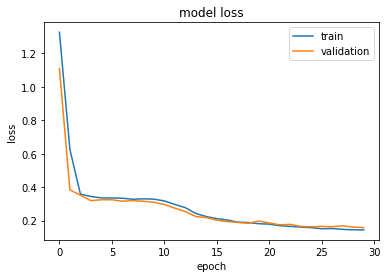

In [22]:
#300 pacientes
plt.plot(historyval.history['loss'])
plt.plot(historyval.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Todos os dados de teste

In [23]:
dataset_dir='/content/drive/MyDrive/testing1'
# Path to mhd images (not gt)
image_ids = []
# r=root, d=directories, f = files
for r, d, f in os.walk(dataset_dir):
    for file in f:    
        if ('ED.mhd' in file) or ('ES.mhd' in file):
            image_ids.append(os.path.join(r, file))

image_ids.sort()
print(image_ids)
images=[]
for image in image_ids:
  #plt.figure(figsize=(12,8))
  #plt.subplot(141)
  image=sitk.GetArrayFromImage(sitk.ReadImage(image,sitk.sitkFloat32))
  image = image[0,:,:] #2D grayscale image
  image=cv2.resize(image,(256,256))
  image=image/255
  image_f=np.stack((image,image,image),axis=2)
  #plt.imshow(image_f)
  images.append(image_f)
  #plt.show()


image_testdataset=np.array(images)

['/content/drive/MyDrive/testing1/patient0001/patient0001_2CH_ED.mhd', '/content/drive/MyDrive/testing1/patient0001/patient0001_2CH_ES.mhd', '/content/drive/MyDrive/testing1/patient0001/patient0001_4CH_ED.mhd', '/content/drive/MyDrive/testing1/patient0001/patient0001_4CH_ES.mhd', '/content/drive/MyDrive/testing1/patient0002/patient0002_2CH_ED.mhd', '/content/drive/MyDrive/testing1/patient0002/patient0002_2CH_ES.mhd', '/content/drive/MyDrive/testing1/patient0002/patient0002_4CH_ED.mhd', '/content/drive/MyDrive/testing1/patient0002/patient0002_4CH_ES.mhd', '/content/drive/MyDrive/testing1/patient0003/patient0003_2CH_ED.mhd', '/content/drive/MyDrive/testing1/patient0003/patient0003_2CH_ES.mhd', '/content/drive/MyDrive/testing1/patient0003/patient0003_4CH_ED.mhd', '/content/drive/MyDrive/testing1/patient0003/patient0003_4CH_ES.mhd', '/content/drive/MyDrive/testing1/patient0004/patient0004_2CH_ED.mhd', '/content/drive/MyDrive/testing1/patient0004/patient0004_2CH_ES.mhd', '/content/drive/MyD

In [24]:
dataset_dir='/content/drive/MyDrive/testing1'
# Path to mhd images (not gt)
mask0_ids = []
mask1_ids = []
mask2_ids = []
mask3_ids = []
# r=root, d=directories, f = files
for r, d, f in os.walk(dataset_dir):
    for file in f:    
        if ('ED.mhd' in file) or ('ES.mhd' in file):
            mask0_ids.append(os.path.join(r, file)[:-4]+"_gt0.mhd")
            mask1_ids.append(os.path.join(r, file)[:-4]+"_gt1.mhd")
            mask2_ids.append(os.path.join(r, file)[:-4]+"_gt2.mhd")
            mask3_ids.append(os.path.join(r, file)[:-4]+"_gt3.mhd")
      
mask0_ids.sort()
print(mask0_ids)
mask1_ids.sort()
mask2_ids.sort()
mask3_ids.sort()
masks=[]

for i in range(200):

  #plt.figure(figsize=(12,8))
  #plt.subplot(441)
  mask0_1=sitk.GetArrayFromImage(sitk.ReadImage(mask0_ids[i],sitk.sitkFloat32))
  mask0_2=cv2.resize(mask0_1,(32,32))
  #plt.imshow(mask0_2)
  #plt.subplot(442)
  mask1_1=sitk.GetArrayFromImage(sitk.ReadImage(mask1_ids[i],sitk.sitkFloat32))
  mask1_2=cv2.resize(mask1_1,(32,32))
  #plt.imshow(mask1_2)
  #plt.subplot(443)
  mask2_1=sitk.GetArrayFromImage(sitk.ReadImage(mask2_ids[i],sitk.sitkFloat32))
  mask2_2=cv2.resize(mask2_1,(32,32))
  #plt.imshow(mask2_2)
  #plt.subplot(444)
  mask3_1=sitk.GetArrayFromImage(sitk.ReadImage(mask3_ids[i],sitk.sitkFloat32))
  mask3_2=cv2.resize(mask3_1,(32,32))
  #plt.imshow(mask3_2)
  #plt.show()
  mask_f=np.stack((mask0_2, mask1_2,mask2_2,mask3_2),axis=2)
  masks.append(mask_f)

mask_testdataset=np.array(masks)

['/content/drive/MyDrive/testing1/patient0001/patient0001_2CH_ED_gt0.mhd', '/content/drive/MyDrive/testing1/patient0001/patient0001_2CH_ES_gt0.mhd', '/content/drive/MyDrive/testing1/patient0001/patient0001_4CH_ED_gt0.mhd', '/content/drive/MyDrive/testing1/patient0001/patient0001_4CH_ES_gt0.mhd', '/content/drive/MyDrive/testing1/patient0002/patient0002_2CH_ED_gt0.mhd', '/content/drive/MyDrive/testing1/patient0002/patient0002_2CH_ES_gt0.mhd', '/content/drive/MyDrive/testing1/patient0002/patient0002_4CH_ED_gt0.mhd', '/content/drive/MyDrive/testing1/patient0002/patient0002_4CH_ES_gt0.mhd', '/content/drive/MyDrive/testing1/patient0003/patient0003_2CH_ED_gt0.mhd', '/content/drive/MyDrive/testing1/patient0003/patient0003_2CH_ES_gt0.mhd', '/content/drive/MyDrive/testing1/patient0003/patient0003_4CH_ED_gt0.mhd', '/content/drive/MyDrive/testing1/patient0003/patient0003_4CH_ES_gt0.mhd', '/content/drive/MyDrive/testing1/patient0004/patient0004_2CH_ED_gt0.mhd', '/content/drive/MyDrive/testing1/pati

In [25]:
print(mask_testdataset.shape)

(200, 32, 32, 4)


#Load do modelo

In [ ]:
from keras.models import load_model
model1 = load_model('/content/drive/MyDrive/ColabNotebooks/model1_val.h5')

In [ ]:
print(image_testdataset.shape)

(200, 256, 256, 3)


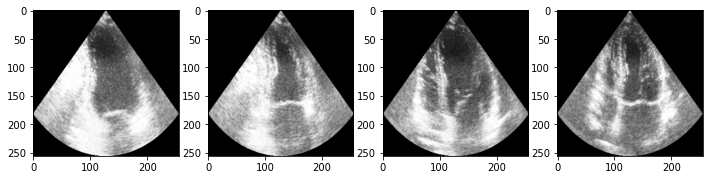

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(141)
plt.imshow(image_dataset[0])
plt.subplot(142)
plt.imshow(image_dataset[1])
plt.subplot(143)
plt.imshow(image_dataset[2])
plt.subplot(144)
plt.imshow(image_dataset[3])
plt.show()

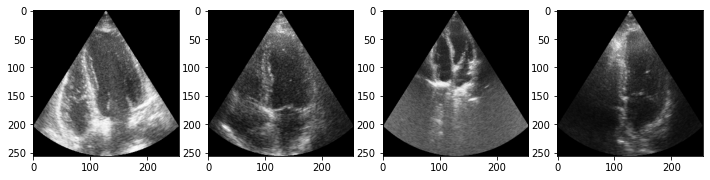

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(141)
plt.imshow(image_testdataset[10])
plt.subplot(142)
plt.imshow(image_testdataset[199])
plt.subplot(143)
plt.imshow(image_testdataset[150])
plt.subplot(144)
plt.imshow(image_testdataset[100])
plt.show()

In [ ]:
previs=model1.predict(image_dataset)

In [ ]:
previs=model1.predict(image_testdataset)

In [ ]:
print(previs.shape)

(200, 32, 32, 4)


(32, 32, 4)


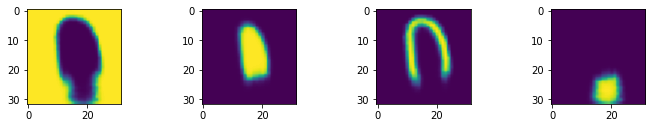

(32, 32, 4)


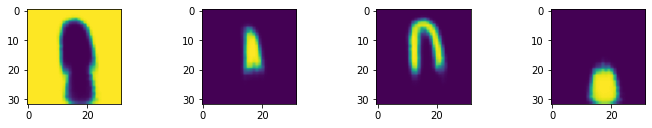

(32, 32, 4)


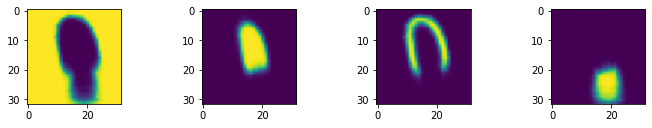

(32, 32, 4)


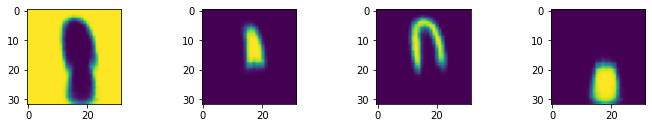

In [ ]:
for i in previs:
  print(i.shape)
  x0=i[:,:,0]
  x1=i[:,:,1]
  x2=i[:,:,2]
  x3=i[:,:,3]
  #print(x.shape)
  plt.figure(figsize=(12,8))
  plt.subplot(441)
  plt.imshow(x0)
  plt.subplot(442)
  plt.imshow(x1)
  plt.subplot(443)
  plt.imshow(x2)
  plt.subplot(444) 
  plt.imshow(x3)
  plt.show()

In [ ]:
x0[0][20]

0.999905

In [ ]:
results = model1.evaluate(image_testdataset, mask_testdataset, batch_size=32)

7/7 [==============================] - 15s 2s/step - loss: 0.1659 - accuracy: 0.9313


In [27]:
def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice

In [ ]:
dice_total=[]
for n in range(200):
  for i in  previs: 
    #print(i.shape)
    pred0=i[:,:,0]
    pred1=i[:,:,1]
    pred2=i[:,:,2]
    pred3=i[:,:,3]
  for f in mask_testdataset:
    y0=f[:,:,0]
    y1=f[:,:,1]
    y2=f[:,:,2]
    y3=f[:,:,3]
  dice1= DICE_COE(pred1,y1)
  #print(dice1)
  dice_total.append(dice1)
  #print(dice_total)
  dice2= DICE_COE(pred2,y2)
  dice_total.append(dice2)
  dice3= DICE_COE(pred3,y3)
  dice_total.append(dice3)

print(dice_total)

[0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772, 0.708, 0.858, 0.772

In [ ]:
import statistics
print(max(dice_total))
print(min(dice_total))
print(statistics.mean(dice_total))
print(statistics.pstdev(dice_total))

0.858
0.708
0.7793333333333333
0.06145639827462141


In [32]:
!pip install hausdorff
from hausdorff import hausdorff_distance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for hausdorff: filename=hausdorff-0.2.6-py3-none-any.whl size=15218 sha256=e767c8c99960bfc4338afe268d4df3cf622bd50b315062450ba7b62a2af17aec
  Stored in directory: /root/.cache/pip/wheels/a1/59/b6/af93f52021bdd019edf4673aa46a2407a0e8339f968168df2c
Successfully built hausdorff


In [ ]:
dH_total=[]
for n in range(200):
  for i in  previs: 
    #print(i.shape)
    pred0=i[:,:,0]
    pred1=i[:,:,1]
    pred2=i[:,:,2]
    pred3=i[:,:,3]
  for f in mask_testdataset:
    y0=f[:,:,0]
    y1=f[:,:,1]
    y2=f[:,:,2]
    y3=f[:,:,3]
  dH1=hausdorff_distance(pred1,y1)
  dH_total.append(dH1)
  dH2=hausdorff_distance(pred2,y2)
  dH_total.append(dH2)
  dH3=hausdorff_distance(pred3,y3)
  dH_total.append(dH3)
print(dH_total)


[1.3067236133138616, 1.6022390667411608, 1.2514787818119444, 1.3067236133138616, 1.6022390667411608, 1.2514787818119444, 1.3067236133138616, 1.6022390667411608, 1.2514787818119444, 1.3067236133138616, 1.6022390667411608, 1.2514787818119444, 1.3067236133138616, 1.6022390667411608, 1.2514787818119444, 1.3067236133138616, 1.6022390667411608, 1.2514787818119444, 1.3067236133138616, 1.6022390667411608, 1.2514787818119444, 1.3067236133138616, 1.6022390667411608, 1.2514787818119444, 1.3067236133138616, 1.6022390667411608, 1.2514787818119444, 1.3067236133138616, 1.6022390667411608, 1.2514787818119444, 1.3067236133138616, 1.6022390667411608, 1.2514787818119444, 1.3067236133138616, 1.6022390667411608, 1.2514787818119444, 1.3067236133138616, 1.6022390667411608, 1.2514787818119444, 1.3067236133138616, 1.6022390667411608, 1.2514787818119444, 1.3067236133138616, 1.6022390667411608, 1.2514787818119444, 1.3067236133138616, 1.6022390667411608, 1.2514787818119444, 1.3067236133138616, 1.6022390667411608,

In [ ]:
print(max(dH_total))
print(min(dH_total))
print(statistics.mean(dH_total))
print(statistics.pstdev(dH_total))

1.6022390667411608
1.2514787818119444
1.3868138206223222
0.15398923198488138


In [29]:
previs=model1.predict(image_testdataset)

In [26]:
results = model1.evaluate(image_testdataset, mask_testdataset, batch_size=32)

7/7 [==============================] - 15s 2s/step - loss: 0.1658 - accuracy: 0.9308


In [30]:
dice_total=[]
for n in range(200):
  for i in  previs: 
    #print(i.shape)
    pred0=i[:,:,0]
    pred1=i[:,:,1]
    pred2=i[:,:,2]
    pred3=i[:,:,3]
  for f in mask_testdataset:
    y0=f[:,:,0]
    y1=f[:,:,1]
    y2=f[:,:,2]
    y3=f[:,:,3]
  dice1= DICE_COE(pred1,y1)
  #print(dice1)
  dice_total.append(dice1)
  #print(dice_total)
  dice2= DICE_COE(pred2,y2)
  dice_total.append(dice2)
  dice3= DICE_COE(pred3,y3)
  dice_total.append(dice3)

print(dice_total)

[0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761, 0.785, 0.884, 0.761

In [31]:
import statistics
print(max(dice_total))
print(min(dice_total))
print(statistics.mean(dice_total))
print(statistics.pstdev(dice_total))

0.884
0.761
0.81
0.05323532661682465


In [33]:
dH_total=[]
for n in range(200):
  for i in  previs: 
    #print(i.shape)
    pred0=i[:,:,0]
    pred1=i[:,:,1]
    pred2=i[:,:,2]
    pred3=i[:,:,3]
  for f in mask_testdataset:
    y0=f[:,:,0]
    y1=f[:,:,1]
    y2=f[:,:,2]
    y3=f[:,:,3]
  dH1=hausdorff_distance(pred1,y1)
  dH_total.append(dH1)
  dH2=hausdorff_distance(pred2,y2)
  dH_total.append(dH2)
  dH3=hausdorff_distance(pred3,y3)
  dH_total.append(dH3)
print(dH_total)


[0.9425828543068144, 1.2832654954385503, 1.0173599419137294, 0.9425828543068144, 1.2832654954385503, 1.0173599419137294, 0.9425828543068144, 1.2832654954385503, 1.0173599419137294, 0.9425828543068144, 1.2832654954385503, 1.0173599419137294, 0.9425828543068144, 1.2832654954385503, 1.0173599419137294, 0.9425828543068144, 1.2832654954385503, 1.0173599419137294, 0.9425828543068144, 1.2832654954385503, 1.0173599419137294, 0.9425828543068144, 1.2832654954385503, 1.0173599419137294, 0.9425828543068144, 1.2832654954385503, 1.0173599419137294, 0.9425828543068144, 1.2832654954385503, 1.0173599419137294, 0.9425828543068144, 1.2832654954385503, 1.0173599419137294, 0.9425828543068144, 1.2832654954385503, 1.0173599419137294, 0.9425828543068144, 1.2832654954385503, 1.0173599419137294, 0.9425828543068144, 1.2832654954385503, 1.0173599419137294, 0.9425828543068144, 1.2832654954385503, 1.0173599419137294, 0.9425828543068144, 1.2832654954385503, 1.0173599419137294, 0.9425828543068144, 1.2832654954385503,

In [34]:
print(max(dH_total))
print(min(dH_total))
print(statistics.mean(dH_total))
print(statistics.pstdev(dH_total))

1.2832654954385503
0.9425828543068144
1.0810694305530313
0.14619698970711809
